Learning generate *adversarial examples* for machine learning models, which can be valuable ways to expose potential weak spots in machine learning systems. Worked from [this paper](https://arxiv.org/abs/1412.6572), which introduced the **Fast Gradient Sign Attack (FGSM)** as a way to fool image classifiers. Lots of code here is copied verbatim from [this tutorial](https://pytorch.org/tutorials/beginner/fgsm_tutorial.html).

Method for finding adversarial examples is motivated by the following image:

<img src="https://pytorch.org/tutorials/_images/fgsm_panda_image.png">

Here, an imperceptible amount of noise is added to a photo of a panda, and the result is that the network classifies the panda as a gibbon!  Our goal is to find these image pairs in a systematic way.

Suppose $J(\theta,x,y)$ is a *loss function* for an image classification task.  Here, $\theta$ contains the parameters of our learned model, e.g. the weights of a neural network; $x$ is an image; and $y$ is a label.  The value $J(\theta,x,y)$ is small when the model correctly predicts label $y$ for image $x$ when parameters $\theta$ are used.

Below is the optimization problem that reasonably could be used to train a machine learning model that fits the data:

$\min_\theta \sum_{i=1}^N J(\theta,x_i,y_i)$, where $N$ is the image-label pairs


Now, suppose we have trained our learning system.  In essence, this means we have chosen a vector of parameters $\theta$.  With $\theta$ fixed, we now can search for an adversarial example!

Training our model requires the gradient $\nabla_\theta J(\theta,x,y)$.  We now seek interpretation of a different gradient:

Since we know that the gradient gives the direction of steepest *ascent*, the gradient $\nabla_x J(\theta,x_i,y_i)$ direction gives a way to perturb image $x_i$ to maximally increase the loss $J$. The $J$ measures how well label $y_i$ is predicted, essentially this is giving the direction to perturb $x_i$ so that its label predicted by the model is farthest from $y_i$.



The inventors of FBSM make an interesting empirical observation, that for purposes of creating adversarial examples it can be better to use $\mathrm{sign}(\nabla_x J(\theta,x_i,y_i))$ instead of just the gradient; this vector puts $\pm1$ in every slot corresponding to the sign of $\nabla_x J$.  They propose a very simple way to get an adversarial example from an image $x_i$:
$$\textrm{adversarial example}_i = x_i + \varepsilon\cdot\mathrm{sign}(\nabla_x J(\theta,x_i,y_i)).$$

The reason we could find an adversarial example using this formula, is the formula itself is a perturbation that makes the loss larger, corresponding to an incorrect label. 

Now, let's implement this strategy for finding adversarial examples.  First, run the code below to set up a pre-trained neural network for classifying MNIST digits:

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

pretrained_model = "lenet_mnist_model.pth"
use_cuda=False

# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor()])),batch_size=1, shuffle=True)

# Define what device we are using
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network
model = Net().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

Your task is to implement the FGSM attack, in the following function:

In [2]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # TODO:  Implement FGSM attack.  Here, you are given the image (x_i),
    # the epsilon value for the attack, and the gradient wrt x of the loss
    # J at x_i
    
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

Run the following code to set up a testing tool, which loops over all the test set, evaluates your FGSM attack code, and checks if an adversarial example was found.

In [3]:
def test( model, device, test_loader, epsilon ):
    correct = 0
    adv_examples = []

    for data, target in test_loader: # Loop over all examples in test set
        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        
        # get the index of the max log-probability, the label of the data point
        init_pred = output.max(1, keepdim=True)[1] 

        # If the initial prediction is wrong, don't attack
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect grad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] 
        
        if final_pred.item() == target.item(): # adversarial example not found
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else: # adversrial example found!
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

Now, we can run our attack!  We have given you a set of $\varepsilon$ values.  Loop over these values and store accuracies and an adversarial example for each.

Epsilon: 0	Test Accuracy = 9810 / 10000 = 0.981
Epsilon: 0.05	Test Accuracy = 9426 / 10000 = 0.9426
Epsilon: 0.1	Test Accuracy = 8510 / 10000 = 0.851
Epsilon: 0.15	Test Accuracy = 6826 / 10000 = 0.6826
Epsilon: 0.2	Test Accuracy = 4301 / 10000 = 0.4301
Epsilon: 0.25	Test Accuracy = 2082 / 10000 = 0.2082
Epsilon: 0.3	Test Accuracy = 869 / 10000 = 0.0869


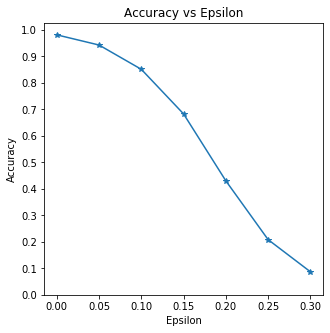

In [4]:
epsilons = [0, .05, .1, .15, .2, .25, .3]

# TODO:  Loop over the epsilons, and append an accuracy and an example output
# from the test() function above
accuracies = []
examples = []

for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

# Now we can plot the accuracies
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

Finally, you can run the code below to display visual examples of potential adversarial examples:

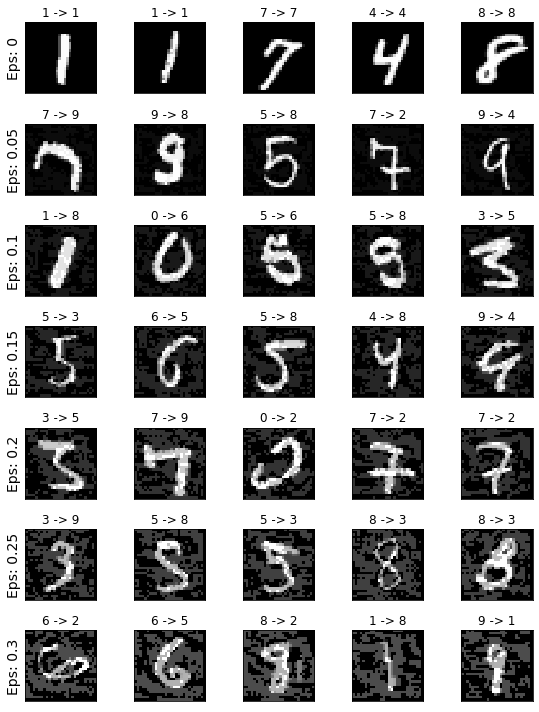

In [5]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()